# Load Data and Draw Graph of Current

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!dir "drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE"

Mounted at /content/drive
EVE1_07Nov_9pm.csv	EVE2_13Nov_9am.csv	EVE3_18Nov_11am.csv	EVE4_27Nov_11am.csv
EVE1_11Nov_9pm.csv	EVE2_14Nov_11am.csv	EVE3_19Nov_9am.csv	EVE4_29Nov_1pm.csv
EVE1_13Nov_12pm.csv	EVE2_15Nov_6pm.csv	EVE3_20Nov_7pm.csv	EVE4_30Nov_12am.csv
EVE1_14Nov_11am.csv	EVE2_16Nov_11am.csv	EVE3_21Nov_8pm.csv	EVE4_31Nov_11am.csv
EVE1_15Nov_3pm.csv	EVE21700_12Feb_7pm.csv	EVE3_22Nov_7pm.csv	EVE4_35Nov_9am.csv
EVE1_16Nov_11am.csv	EVE2_17Nov_11am.csv	EVE3_23Nov_7pm.csv	EVE4_37Nov_10am.csv
EVE1_17Nov_11am.csv	EVE2_18Nov_11am.csv	EVE3_25Nov_5pm.csv	EVE4_39Nov_8pm.csv
EVE1_18Nov_11am.csv	EVE2_19Nov_9am.csv	EVE3_26Nov_7pm.csv	EVE4_40Nov_6pm.csv
EVE1_19Nov_9am.csv	EVE2_20Nov_7pm.csv	EVE3_28Nov_10am.csv	EVE4_41Nov_11am.csv
EVE1_20Nov_3pm.csv	EVE2_21Nov_8pm.csv	EVE3_29Nov_10am.csv	EVE4\ cleaned\ mAh.png
EVE1_20Nov_9pm.csv	EVE2_22Nov_7pm.csv	EVE3_30Nov_11am.csv	EVE5_27Nov_10am.csv
EVE1_21Nov_8pm.csv	EVE2_23Nov_7pm.csv	EVE3_31Nov_10am.csv	EVE6_28Nov_10am.csv
EVE1_22Nov_8pm.csv	EVE2_25Nov_5pm

In [ ]:
def makePdf(batteryName, showDetailed=False):
  folder = "drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/"
  folder2 = "drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/"

  df_test = pd.read_excel(folder2+"Battery_Testing_Data.xlsx",sheet_name="EVE 18650")
  df_test.insert(0, 'Empty_Column', '')
  df_result = pd.DataFrame()
  print("-------------------------- Data forBattery:",batteryName,"--------------------------------------------------------------")
  outputFilename = folder+"output"+batteryName+".pdf"
  unsorted_files = glob.glob(f"{folder}/{batteryName}_*.csv")
  # Initialize an empty DataFrame to store the merged data
  print(unsorted_files)
  df_test=df_test[((df_test['Battery_ID']==batteryName) | (df_test['Battery_ID']==' '+batteryName)) & (df_test['Distance']>0) & (df_test['Distance']<300)]
  df_test['Battery_ID'] = df_test['Battery_ID'].replace(' '+batteryName,batteryName)
  csv_files = sorted(unsorted_files, key=lambda x: int(x.split('_')[1][:2]))
  print(csv_files)
  df = pd.DataFrame()
  first_file = True
  # Iterate through each CSV file and concatenate it to the merged_data DataFrame
  for csv_file in csv_files:
    print(csv_file)
    df_file = pd.read_csv(csv_file)
    if not first_file:
      df_file = df_file.iloc[1:]
    if ' Cell Diff' in df_file.columns:
      df_file.rename(columns={" Cell Diff": "Cell Diff"}, inplace = True)
      print("Wrong Cell Difference column found in "+csv_file)
      df = pd.concat([df, df_file], ignore_index=True)
    else:
      df = pd.concat([df, df_file], ignore_index=True)
    print("File Size=",len(df.index))
    first_file=False
  # Define the window size for rolling calculations
  window_size = 20

  # Calculate the rolling sum of positive values
  df['Charging'] = df['Current'].apply(lambda x: 1 if x >= 0 else 0).rolling(window=window_size).sum().apply(lambda x: True if x>window_size-1 else False)
  df['Cycle'] = df['Charging'].diff().cumsum()
  df['Interval'] = df['Seconds'].diff()
  df = df[df.Current<100]
  mask = df.columns.str.contains('Cell .*')
  mask[7]=False
  print(mask)
  df['minCellVolts'] = df.loc[:,mask].min(axis=1)
  plt.figure(figsize=(28, 6))
  plt.plot(df['Current'], marker='o', linestyle='-')
  plt.plot(df['Charging']*10, marker='o', linestyle='-')
  plt.plot(df['Cycle'], marker='o', linestyle='-')
  plt.title('Current')
  plt.xlabel('Index')
  plt.ylabel('Current')
  plt.grid(True)
  plt.show()
  plt.close()
  with PdfPages(outputFilename) as pdf:
      #plt.figure(figsize=(58, 6))
      #plt.plot(df['Current'], marker='o', linestyle='-')
      #plt.title('Current')
      #plt.xlabel('Index')
      #plt.ylabel('Current')
      #plt.grid(True)
      #pdf.savefig(plt.gcf())
      #plt.close()
      if (batteryName=="EVE2") or (batteryName=="EVE3"):
        # Plotting an empty plot
        plt.figure(figsize=(18, 46))
        # Hide x and y axis lines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        # Adding column names to the header
        for j, col in enumerate(df_test.columns):
            plt.text(j, len(df_test.index) + 0.5, col, ha='center', va='center', fontdict={'color': 'black'})
        df_test['Date'] = pd.to_datetime(df_test['Date']).dt.date
        # Adding text values to the plot
        for i in range(len(df_test.index)):
            for j in range(len(df_test.columns)):
                plt.text(j, len(df_test.index) - i, str(df_test.iloc[i, j]), ha='center', va='center', fontdict={'color': 'black'})

        # Adjusting ticks and labels
        plt.xticks(range(len(df_test.columns)), labels=df_test.columns)
        plt.yticks(range(len(df_test.index)), labels=df_test.index)


        # Hide grid lines
        plt.grid(False)
        # Save the figure to the PDF file
        pdf.savefig(plt.gcf())

        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)

        plt.figure(figsize=(36, 10))
        df_test['Color'] = 'blue'
        df_test.loc[df_test.Tester_Name=='Atiq', 'Color'] = 'maroon'
        df_test.loc[df_test.Tester_Name=='Salman', 'Color'] = 'green'
        #df_bat_test = df_test[df_test.Battery_ID==batteryName]
        #plt.plot(df_bat_test['Cycle_Number'],df_bat_test['Distance'], marker='o', linestyle='-')
        plt.bar(df_test['Cycle_Number'], df_test['Distance'], color = df_test['Color'], width = 0.4)
        # Adding values over each bar
        for i, val in enumerate(df_test['Distance']):
          plt.text(i, val + 0.5, str(val), ha='center', va='bottom')
        plt.title('Distance of '+str(batteryName))
        plt.xlabel('Cycle Number \n Tester Name \n Gear')
        print("DF test index")
        print(df_test["Cycle_Number"], df_test["Tester_Name"], df_test["Gear"])
        label_ticks = [f"C:{int(cycle)}\n{tester}\nG:{int(gear)}" for cycle, tester, gear in zip(df_test["Cycle_Number"], df_test["Tester_Name"], df_test["Gear"])]
        print(range(len(df_test.index)))
        print(label_ticks)
        plt.xticks(range(len(df_test.index)), labels = label_ticks, rotation=0)
        plt.ylabel('Distance')
        plt.grid(True)
        pdf.savefig(plt.gcf())

      charging_mAh = []
      discharging_mAh = []
      chargingmaxCellDiffList = []
      dischargingmaxCellDiffList = []
      for i in range(int(df.Cycle.max()+1)):

          #df_result['Cycle'] = i
          locdf = df[(df.Cycle == i) & (df.Current < 100)]
          valueCount = locdf.Charging.count()
          print("Processing Cycle "+str(i))
          if valueCount>30:
              #df_result['ValueCount'].iloc[i] = valueCount
              title=str(valueCount)+" values for"
              maxCellDiff = locdf['Cell Diff'].max() / 1000
              #df_result[''].iloc[i]
              cellDiffatEnd = (locdf['Cell Diff'].iloc[-1])/1000
              if locdf.Charging.max() == True:
                  title += " Charging Cycle#:"
                  title += str(len(charging_mAh))
                  title += " ("
                  mAhdf = locdf[(locdf.Interval<10) & (locdf.Interval>1)]
                  mAhdf_mAh = ((mAhdf['Current']*mAhdf['Interval'])*1000/3600).cumsum()
                  mAh = int(mAhdf_mAh.iloc[-1])
                  charging_mAh.append(mAh)
                  title+= "max Current: "+str(locdf.Current.max())+"A"
                  title+= ",mAh:"+str(mAh)
                  chargingmaxCellDiffList.append(maxCellDiff)
              elif locdf.Charging.max() == False:
                  title += " Discharging Cycle#:"
                  title += str(len(discharging_mAh))
                  title += " ("
                  mAhdf = locdf[(locdf.Interval<10) & (locdf.Interval>1)]
                  mAhdf_mAh = (((-1)*mAhdf['Current']*mAhdf['Interval'])*1000/3600).cumsum()
                  mAh = int(mAhdf_mAh.iloc[-1])
                  discharging_mAh.append(mAh)
                  title+=" Max Current: "+str(int(locdf.Current.min()))+"A"
                  title+=", Avg Current: "+str(int(locdf.Current.mean()))+"A"
                  title+= ", mAh (valid for DC only):"+str(mAh)
                  dischargingmaxCellDiffList.append(maxCellDiff)
                  #if batteryName in ['EVE1','EVE4']:
                  #  plt.figure(figsize=(18, 6))
                  #  plt.plot(mAhdf_mAh, mAhdf['Voltage'], marker='o', linestyle='-')
                  #  plt.title('Voltage')
                  #  plt.xlabel('mAh')
                  #  plt.ylabel('Voltage')
                  #  plt.grid(True)
                  #  pdf.savefig(plt.gcf())

              title += "\n Duration (mins):"+str(int((locdf.Seconds.iloc[-30] - locdf.Seconds.iloc[0]) / 60))
              title+=", Max Cell Diff:"+str(maxCellDiff)+"V "
              title+=", Cell Diff at end: "+str(cellDiffatEnd)+"V ) "
              #print("Start Volts:", locdf.Voltage.iloc[0])
              #print("End Volts:", locdf.Voltage.iloc[-1])
              #print("Max Cell Difference Volts: ", maxCellDiff)
              #print("Cell Diff at end:", cellDiffatEnd)
              if maxCellDiff >= 0.8:
                  print("!!Cell Difference in Dangerous Region!!")

              if showDetailed:
                fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(frameon=False), figsize=(14, 8))
                fig.subplots_adjust(hspace=0.0)
                ax1t = ax1.twinx()
                ax2t = ax2.twinx()
                ax1.grid()
                ax2.grid()
                ax1.set_title(title)
                ax1.plot(locdf.index, locdf['Current'], 'g-', marker='o', label="Current")
                ax1t.plot(locdf.index, locdf['Voltage'], 'b-', label="Voltage")
                ax2.plot(locdf.index, locdf['Cell Diff'] / 1000, 'b-', marker='o', label="Cell Diff")
                ax2t.plot(locdf.index, locdf['minCellVolts'] / 1000, 'g-')
                ax2t.plot(locdf.index, locdf['Cell 2'] / 1000, 'r-')
                ax2.set_xlabel('Index')
                ax1.set_ylabel('Current', color='g')
                ax1t.set_ylabel('Voltage', color='b')
                ax2.set_ylabel('Cell Diff', color='b')
                ax2.set_yticks(np.arange(0, 1.2, 0.1))
                ax2t.set_ylabel('Lowest Cell Voltage', color='g')
                plt.grid(True)

                # Save the current figure to the PDF
                pdf.savefig(fig)

                # Close the figure
                plt.close()

              # Your existing code to print additional information


      plt.figure(figsize=(18, 6))
      plt.plot(chargingmaxCellDiffList, color='g', marker='o', linestyle='-')
      plt.plot(dischargingmaxCellDiffList, color='r', marker='o')
      plt.title('Charging Discharging max. Cell Difference (green=Charging, red=Discharging)')
      plt.xlabel('Cycles')
      plt.ylabel('V')
      plt.xticks(range(max(len(charging_mAh),len(discharging_mAh))))
      plt.grid(True)
      pdf.savefig(plt.gcf())

      plt.figure(figsize=(18, 6))

      # remove_mAh = {'EVE1':0,'EVE2':0,'EVE3':0,'EVE4':0, 'EVE5':0,'EVE6':0}
      # remove_mah = {'EVE7':0}

      plt.plot(charging_mAh, color='g', marker='o', linestyle='-')
      for i, val in enumerate(charging_mAh):
        plt.text(i, val + 25, str(val), fontsize=6, ha='center', color='g')
      #plt.plot(discharging_mAh, color='r', marker='o')
      plt.title('RawCharging Discharging mAh (green=Charging, red=Discharging)')
      #for i, val in enumerate(discharging_mAh):
      #  plt.text(i, val + 10, str(val), fontsize=6, ha='center', va='bottom', color='r')
      plt.xlabel('Cycles')
      plt.ylabel('mAh')
      plt.xticks(range(max(len(charging_mAh),len(discharging_mAh))))
      plt.grid(True)
      pdf.savefig(plt.gcf())

      plt.figure(figsize=(18, 6))
      remove_mAh = {'EVE1':6,'EVE2':6,'EVE3':3,'EVE4':8}
      # remove_mah = {'EVE7':0}
      remove_mah = {'NMC1':0}
      remove_mah = {'EVE27100':0}
      #if batteryName in remove_mAh:
      #  cleaned_mAh = charging_mAh[remove_mAh[batteryName]:]
      #else:
      #  cleaned_mAh = charging_mAh
      cleaned_mAh = [item for item in charging_mAh if item > 5000 and item < 25000]
      plt.plot(cleaned_mAh, color='g', marker='o', linestyle='-')
      for i, val in enumerate(cleaned_mAh):
        plt.text(i, val + 25, str(val), fontsize=6, ha='center', va='top', color='g')
      #plt.plot(discharging_mAh, color='r', marker='o')
      plt.title('Cleaned Charging Discharging mAh (green=Charging, red=Discharging)')
      #for i, val in enumerate(discharging_mAh):
      #  plt.text(i, val + 10, str(val), fontsize=6, ha='center', va='bottom', color='r')
      plt.xlabel('Cycles')
      plt.ylabel('mAh')
      plt.xticks(range(max(len(charging_mAh),len(discharging_mAh))))
      plt.grid(True)
      pdf.savefig(plt.gcf())

  # The PDF will be saved with both text and graphs


-------------------------- Data forBattery: NMC1 --------------------------------------------------------------
['drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/NMC1_11Jan_11am.csv', 'drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/NMC1_35Jan_7pm.csv', 'drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/NMC1_42Jan_7pm.csv']
['drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/NMC1_11Jan_11am.csv', 'drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE/NMC1_35Jan_7pm.csv', 'drive/MyDrive/AIM Motors Docs/Product Technical Documentation/Engineering Documentation/Battery Testing Data/18650 batteries EVE

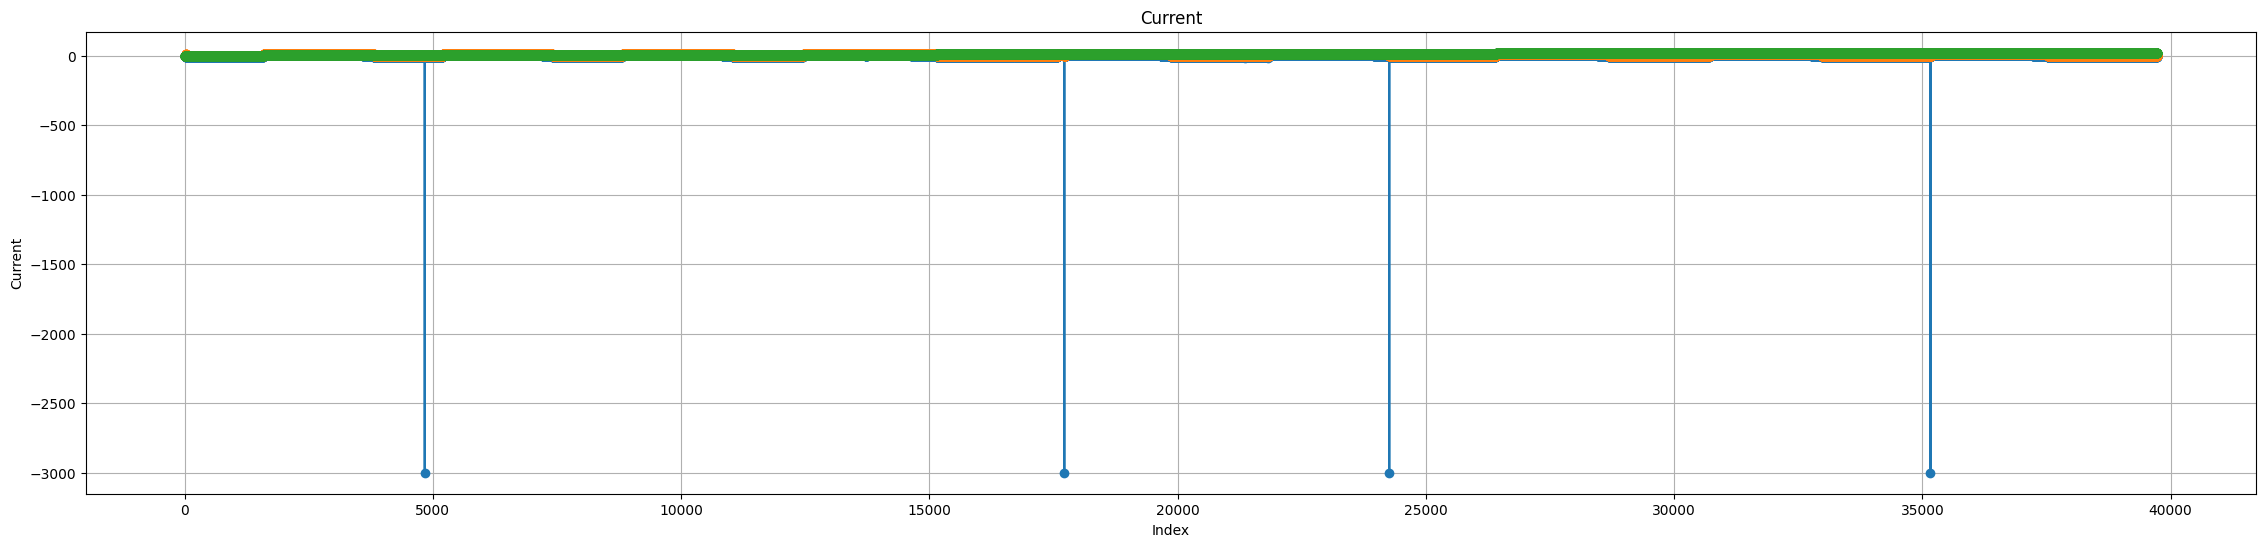

Processing Cycle 0
Processing Cycle 1
Processing Cycle 2
Processing Cycle 3
Processing Cycle 4
Processing Cycle 5
Processing Cycle 6
Processing Cycle 7
Processing Cycle 8
Processing Cycle 9
Processing Cycle 10
Processing Cycle 11
Processing Cycle 12
Processing Cycle 13
Processing Cycle 14
Processing Cycle 15
Processing Cycle 16
Processing Cycle 17
Processing Cycle 18
Processing Cycle 19
Processing Cycle 20
Processing Cycle 21
Processing Cycle 22


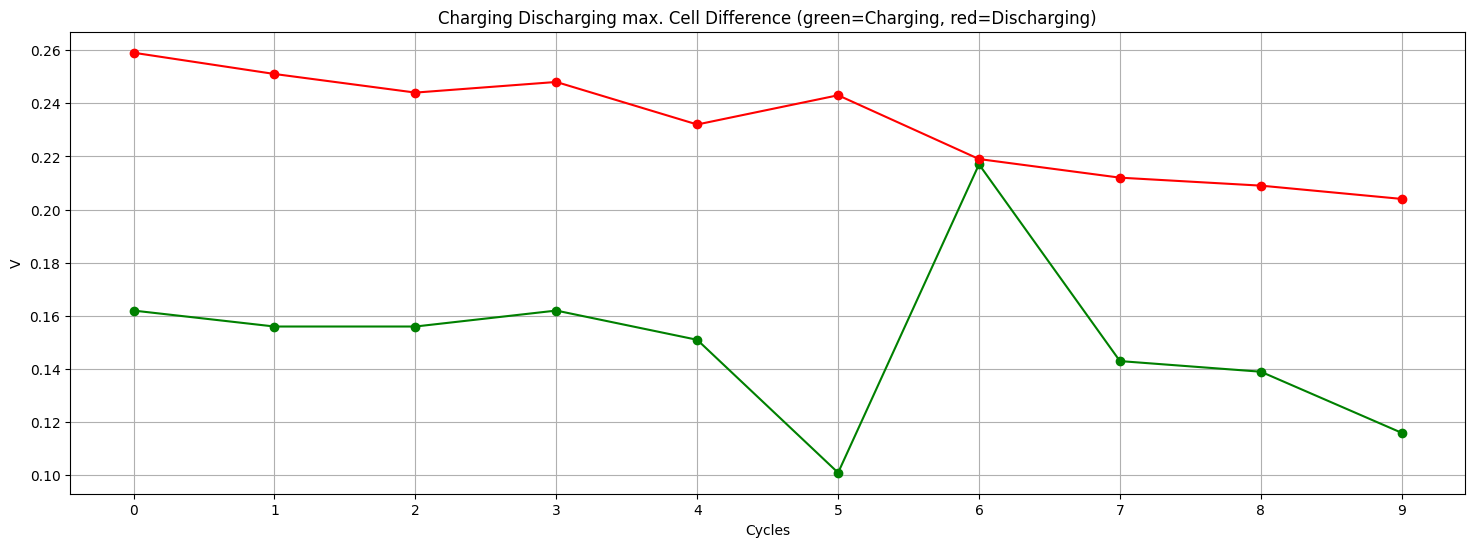

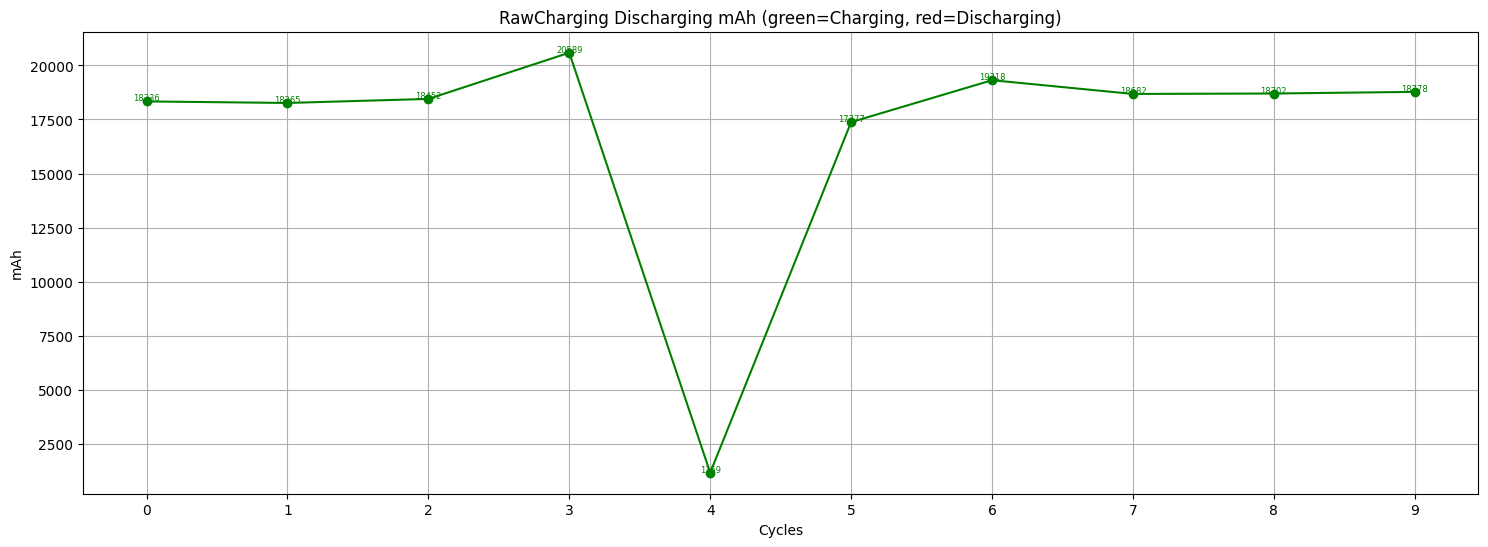

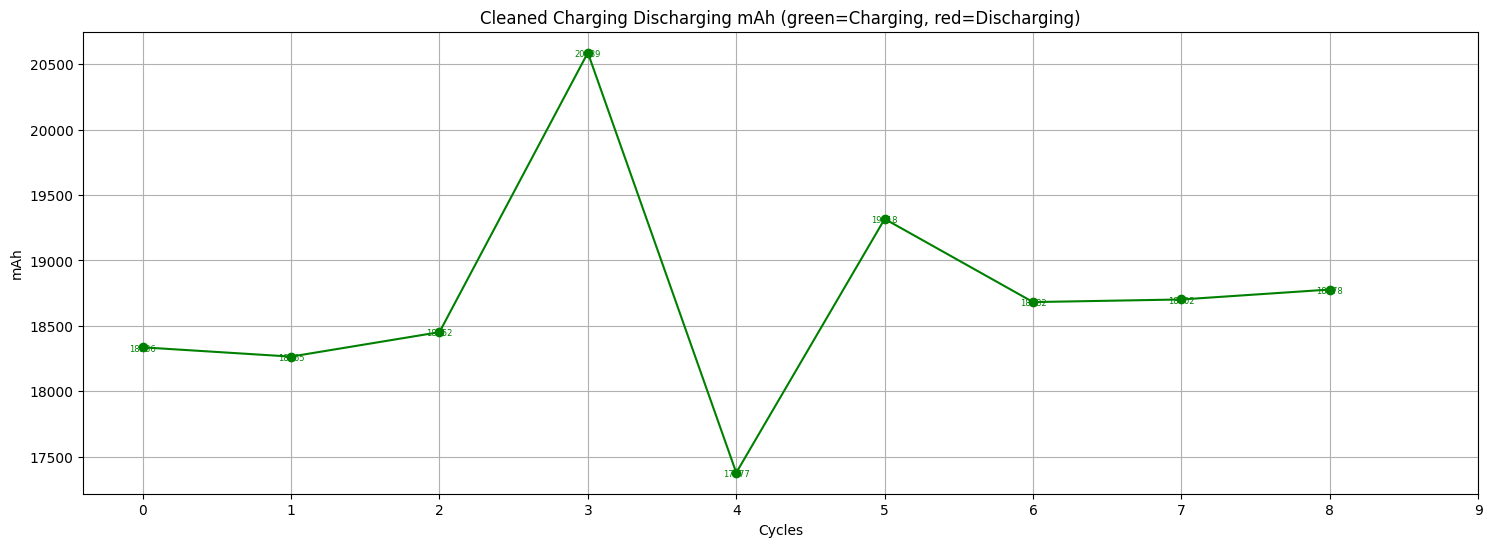

In [ ]:
# batteryNames = ["EVE2","EVE3","EVE4"]
# batteryNames = ["EVE2","EVE3"]
#batteryNames = ["EVE5","EVE6"]
# batteryNames = ["EVE8"]
batteryNames = ["NMC1"]
# batteryNames = ["EVE21700"]

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

for batteryName in batteryNames:
  makePdf(batteryName, showDetailed=False)